In [1]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''


'Machine learning is the study of computer algorithms that improve automatically through experience. It is seen as a subset of artificial intelligence. Machine learning algorithms build a mathematical model based on sample data, known as training data, in order to make predictions or decisions without being explicitly programmed to do so. Machine learning algorithms are used in a wide variety of applications, such as email filtering and computer vision, where it is difficult or infeasible to develop conventional algorithms to perform the needed tasks.'

tut link : https://jaketae.github.io/study/word2vec/

## Tokenization 

In [2]:
import re

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [7]:
tokens = tokenize(text=text)
print(f" token type {type(tokens)}  length of tokens {len(tokens)}")
print(f"sample tokens : {tokens[0:4]}")

 token type <class 'list'>  length of tokens 84
sample tokens : ['machine', 'learning', 'is', 'the']


In [8]:
# this function is to create lookup tables for all the tokens

def mapping(tokens):
    word_to_id = {}
    id_to_word = {}

    for index, token in enumerate(set(tokens)):
        word_to_id[token] = index
        id_to_word[index] = token

    return word_to_id, id_to_word

In [13]:
# lookup tables created 
word_to_id, id_to_word = mapping(tokens=tokens)

from pprint import pprint
pprint(f" word_to_id {word_to_id}  id_to_word {id_to_word}")
pprint(f" {len(word_to_id)} = UNIQUE TOKENS = { len(set(tokens))}")

(" word_to_id {'artificial': 0, 'study': 1, 'improve': 2, 'learning': 3, 'is': "
 "4, 'difficult': 5, 'that': 6, 'perform': 7, 'do': 8, 'the': 9, 'are': 10, "
 "'data': 11, 'order': 12, 'develop': 13, 'decisions': 14, 'to': 15, 'it': 16, "
 "'being': 17, 'intelligence': 18, 'vision': 19, 'through': 20, 'in': 21, "
 "'mathematical': 22, 'subset': 23, 'make': 24, 'explicitly': 25, 'computer': "
 "26, 'programmed': 27, 'a': 28, 'so': 29, 'needed': 30, 'sample': 31, "
 "'conventional': 32, 'model': 33, 'automatically': 34, 'used': 35, 'build': "
 "36, 'algorithms': 37, 'machine': 38, 'on': 39, 'email': 40, 'training': 41, "
 "'without': 42, 'experience': 43, 'variety': 44, 'based': 45, 'such': 46, "
 "'seen': 47, 'wide': 48, 'of': 49, 'known': 50, 'where': 51, 'or': 52, "
 "'filtering': 53, 'applications': 54, 'infeasible': 55, 'as': 56, 'and': 57, "
 "'tasks': 58, 'predictions': 59}  id_to_word {0: 'artificial', 1: 'study', 2: "
 "'improve', 3: 'learning', 4: 'is', 5: 'difficult', 6: 'tha

# Generating Dataset for training

In [36]:
import numpy as np
np.random.seed(42) # for reproducibility
from pprint import pprint


def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res
        

def concat(*iterables):
    for iterable in iterables:
        yield from iterable    


def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    train = []

    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            train.append([tokens[i], tokens[j]])
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    pprint(train)
    return np.asarray(X), np.asarray(y)

X, y = generate_training_data(tokens, word_to_id, 2)
print(f"X {X.shape} y {y.shape}")

[['machine', 'learning'],
 ['machine', 'is'],
 ['learning', 'machine'],
 ['learning', 'is'],
 ['learning', 'the'],
 ['is', 'machine'],
 ['is', 'learning'],
 ['is', 'the'],
 ['is', 'study'],
 ['the', 'learning'],
 ['the', 'is'],
 ['the', 'study'],
 ['the', 'of'],
 ['study', 'is'],
 ['study', 'the'],
 ['study', 'of'],
 ['study', 'computer'],
 ['of', 'the'],
 ['of', 'study'],
 ['of', 'computer'],
 ['of', 'algorithms'],
 ['computer', 'study'],
 ['computer', 'of'],
 ['computer', 'algorithms'],
 ['computer', 'that'],
 ['algorithms', 'of'],
 ['algorithms', 'computer'],
 ['algorithms', 'that'],
 ['algorithms', 'improve'],
 ['that', 'computer'],
 ['that', 'algorithms'],
 ['that', 'improve'],
 ['that', 'automatically'],
 ['improve', 'algorithms'],
 ['improve', 'that'],
 ['improve', 'automatically'],
 ['improve', 'through'],
 ['automatically', 'that'],
 ['automatically', 'improve'],
 ['automatically', 'through'],
 ['automatically', 'experience'],
 ['through', 'improve'],
 ['through', 'automatical

## The Embedding Model

60 is the size of our corpus, or the number of unique tokens we have in the original text. Since we have one-hot encoded both the input and output as 60-dimensional sparse vectors, this is expected.



At this point, you might be wondering how it is that training a neural network that predicts some nearby context word given an input token can be used to embed words into vectors. After all, the output of the network is going to be some probability vector that passed through a softmax layer, not an embedding vector.

This is entirely correct, and this is a question that came to my mind as well. However, this is the part that gets the most interesting: the rows of the intermediate weight matrix is the embedding we are looking for! 

In [61]:
from torch import  nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

In [86]:

vocab_size = 60 # we have 60 dimensional hot encoded vectors
n_embedding = 5 # dimension of embedding vector 

torch.manual_seed(42)

class MyEmbeddingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_embedding = nn.Linear(vocab_size,n_embedding)
        self.out_embedding = nn.Linear(n_embedding, vocab_size)
        
    def forward(self,x):
        return self.out_embedding(self.in_embedding(x))
    
model =  MyEmbeddingModel()

# model.in_embedding(torch.tensor(X[0],dtype=torch.float32))
# model.forward(torch.tensor(X[0],dtype=torch.float32))

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 1000
losses = []

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')
    


/var/folders/27/n5gxzmy10mx08j62x813rw080000gn/T/ipykernel_88126/4275027908.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/var/folders/27/n5gxzmy10mx08j62x813rw080000gn/T/ipykernel_88126/4275027908.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


Epoch [1/1000], Loss: 4.077897071838379
Epoch [2/1000], Loss: 4.0768232345581055
Epoch [3/1000], Loss: 4.075752258300781
Epoch [4/1000], Loss: 4.07468318939209
Epoch [5/1000], Loss: 4.073616027832031
Epoch [6/1000], Loss: 4.072551727294922
Epoch [7/1000], Loss: 4.071489334106445
Epoch [8/1000], Loss: 4.07042932510376
Epoch [9/1000], Loss: 4.069371223449707
Epoch [10/1000], Loss: 4.068314075469971
Epoch [11/1000], Loss: 4.067259788513184
Epoch [12/1000], Loss: 4.066206455230713
Epoch [13/1000], Loss: 4.065154552459717
Epoch [14/1000], Loss: 4.064104080200195
Epoch [15/1000], Loss: 4.063054084777832
Epoch [16/1000], Loss: 4.062005996704102
Epoch [17/1000], Loss: 4.060957908630371
Epoch [18/1000], Loss: 4.059909820556641
Epoch [19/1000], Loss: 4.058862686157227
Epoch [20/1000], Loss: 4.0578155517578125
Epoch [21/1000], Loss: 4.056767463684082
Epoch [22/1000], Loss: 4.055719375610352
Epoch [23/1000], Loss: 4.054671287536621
Epoch [24/1000], Loss: 4.053621292114258
Epoch [25/1000], Loss: 4.

In [90]:
# model.in_embedding()

word = one_hot_encode(id=word_to_id['intelligence'], vocab_size=60)
t1 = model.in_embedding(torch.tensor(word,dtype=torch.float32))


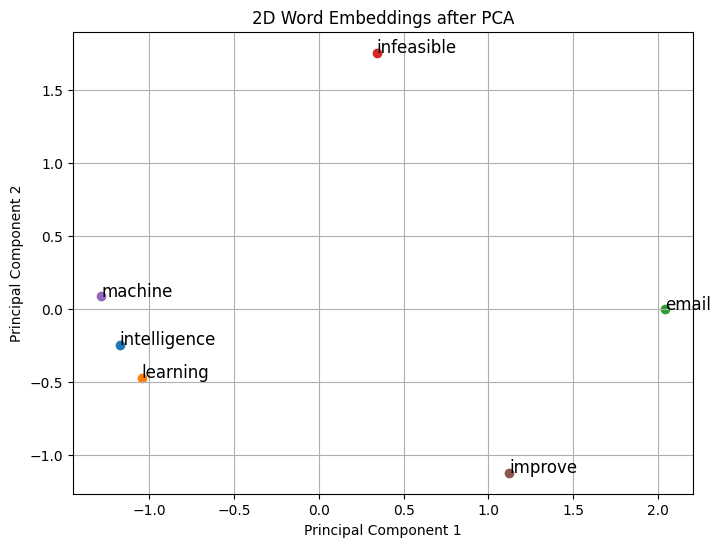

In [99]:
def getEmbedding(w):
    word = one_hot_encode(id=word_to_id[w], vocab_size=60)
    t1 = model.in_embedding(torch.tensor(word,dtype=torch.float32))
    return t1

import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming getEmbedding function returns high-dimensional word embeddings

# Example words
words = ['intelligence', 'learning', 'email', 'infeasible' , 'machine', 'improve' ]

# Collecting embeddings for each word
embeddings = [getEmbedding(word) for word in words]
embeddings = torch.stack(embeddings).detach().numpy()

# Apply PCA to reduce the dimension to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot 2D embeddings
plt.figure(figsize=(8, 6))
for i, word in enumerate(words):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], word, fontsize=12)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Word Embeddings after PCA')
plt.grid()
plt.show()


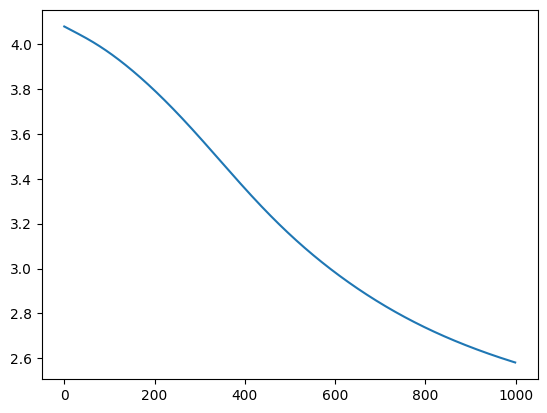

In [87]:
plt.plot(losses)